<a href="https://colab.research.google.com/github/Rabia-Akhtr/Time-Series-Modelling-Case-Study/blob/main/Assignment_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A case study on modelling some real data, finding the best model to describe the data, then making a forecast.

I will use the Oil prices data.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Data manipulation
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# System
import warnings
warnings.filterwarnings("ignore")

# Fix random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Read in the data and check its OK

data = pd.read_csv('/content/drive/MyDrive/Advance Research/Assignment 1/oil_price.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)
data.head()

,Price
Date,
2020-07-01,42.18
2020-07-02,43.19
2020-07-03,42.92
2020-07-06,42.73
2020-07-07,43.28


In [4]:
data.tail()

,Price
Date,
NaT,NaN
NaT,NaN
NaT,NaN
NaT,NaN
NaT,NaN


In [5]:
data = data.dropna()

In [6]:
# Read data
pd.concat([data.head(), data.tail()])

,Price
Date,
2020-07-01,42.18
2020-07-02,43.19
2020-07-03,42.92
2020-07-06,42.73
2020-07-07,43.28
2022-12-22,79.58
2022-12-23,82.45
2022-12-28,81.70
2022-12-29,80.96


In [7]:
monthly = data['Price'].resample('M').mean().dropna()
print(f"Loaded {len(monthly)} months from {monthly.index.min().date()} to {monthly.index.max().date()}")

Loaded 30 months from 2020-07-31 to 2022-12-31


In [8]:
# Null values
data.isna().sum()

,0
Price,0


In [9]:
# Get the shape of the dataset
print(data.shape)

(635, 1)


We scale the oil price data to the range [0, 1] to make the LSTM model training more stable and efficient. Scaling also helps prevent issues with very large or small values that can slow learning.

In [10]:
def scale_data(series: pd.Series, feature_range: tuple = (0, 1)):
    """
    Scale a 1D numeric pandas Series to a given range.
    Returns the scaled array and fitted scaler.
    """
    values = series.values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=feature_range)
    scaled_array = scaler.fit_transform(values)
    return scaled_array, scaler

# Call the function and view results
monthly_scaled, scaler = scale_data(monthly)
print("Scaled array shape:", monthly_scaled.shape)

Scaled array shape: (30, 1)


We convert the time series into input/output pairs for supervised learning.
Each input sequence consists of look_back previous values (e.g., last 12 months), and the target is the next value.
We also split the data into training and testing sets.

In [11]:
## One‐Step Sequence Function
import numpy as np

def create_one_step_sequences(scaled_array: np.ndarray, look_back: int = 12):
    """
    Build X, y for one‐step‐ahead forecasting:
      X[i] = scaled_array[i : i+look_back]
      y[i] = scaled_array[i+look_back, 0]
    """
    X, y = [], []
    total = len(scaled_array)
    for i in range(total - look_back):
        X.append(scaled_array[i : i + look_back])
        y.append(scaled_array[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 12
X, y = create_one_step_sequences(monthly_scaled, look_back=look_back)
print("X shape:", X.shape, "y shape:", y.shape)


X shape: (18, 12, 1) y shape: (18,)


In [12]:
# Train/Validation Split
split_idx = int(len(X) * 0.8)
X_train, y_train = X[:split_idx], y[:split_idx]
X_val,   y_val   = X[split_idx:], y[split_idx:]
print("Train samples:", X_train.shape[0], "Val samples:", X_val.shape[0])


Train samples: 14 Val samples: 4


# Build and Train the LSTM Model

We will now define and train the LSTM model using our processed data.
The model will learn to predict the next oil price given the previous 12 months of prices.
We will evaluate the model’s performance using the test set.

In [13]:
# Define Model‐Building Function for One‐Step (Iterative) Forecast (No Dropout)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def build_lstm_model(input_shape, units=50, optimizer='adam'):
    """
    Build and compile a one-step LSTM model for iterative forecasting.
    """
    model = Sequential([
        LSTM(units, activation='tanh', input_shape=input_shape),
        Dense(1)    # predict the next single step
    ])
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Example instantiation with look_back=12:
model = build_lstm_model(input_shape=(look_back, 1), units=50)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

# **Hypertune Parameters with Grid Search**

In [14]:
# Hyperparameter Tuning Loop (iterative one‐step model with dropout + lr tuning + EarlyStopping)
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

units_list   = [32, 50, 64]
batch_sizes  = [8, 16, 32]
dropout_list = [0.1, 0.2, 0.3]
lr_list      = [1e-2, 1e-3, 1e-4]

best_rmse, best_params = np.inf, None

for units in units_list:
    for dropout in dropout_list:
        for batch_size in batch_sizes:
            for lr in lr_list:
                print(f"Try: units={units}, batch={batch_size}, "
                      f"dropout={dropout}, lr={lr}")

                # build model dynamically per-iteration
                m = Sequential()
                m.add(LSTM(units, activation='tanh', input_shape=(look_back, 1)))
                if dropout > 0.0:
                    m.add(Dropout(dropout))
                m.add(Dense(1))

                # compile with Adam at this learning rate
                optimizer = Adam(learning_rate=lr)
                m.compile(optimizer=optimizer, loss='mse')

                # early stopping on val_loss
                es = EarlyStopping(
                    monitor='val_loss',
                    patience=5,
                    restore_best_weights=True,
                    verbose=0
                )

                # train with validation data
                hist = m.fit(
                    X_train, y_train,
                    epochs=50,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=[es],
                    verbose=0
                )

                # one-step validation RMSE
                val_pred = m.predict(X_val, verbose=0).flatten()
                rmse = np.sqrt(mean_squared_error(y_val, val_pred))
                print(f"  Val RMSE: {rmse:.4f}")

                if rmse < best_rmse:
                    best_rmse, best_params = rmse, (units, batch_size, dropout, lr)
                    best_model, best_history = m, hist

print(f"\nBest → units={best_params[0]}, batch={best_params[1]}, "
      f"dropout={best_params[2]}, lr={best_params[3]}, RMSE={best_rmse:.4f}")


Try: units=32, batch=8, dropout=0.1, lr=0.01
  Val RMSE: 0.1098
Try: units=32, batch=8, dropout=0.1, lr=0.001
  Val RMSE: 0.0547
Try: units=32, batch=8, dropout=0.1, lr=0.0001
  Val RMSE: 0.1099
Try: units=32, batch=16, dropout=0.1, lr=0.01
  Val RMSE: 0.0657
Try: units=32, batch=16, dropout=0.1, lr=0.001


  Val RMSE: 0.0576
Try: units=32, batch=16, dropout=0.1, lr=0.0001


  Val RMSE: 0.2639
Try: units=32, batch=32, dropout=0.1, lr=0.01
  Val RMSE: 0.1759
Try: units=32, batch=32, dropout=0.1, lr=0.001
  Val RMSE: 0.0541
Try: units=32, batch=32, dropout=0.1, lr=0.0001
  Val RMSE: 0.3713
Try: units=32, batch=8, dropout=0.2, lr=0.01
  Val RMSE: 0.0788
Try: units=32, batch=8, dropout=0.2, lr=0.001
  Val RMSE: 0.0549
Try: units=32, batch=8, dropout=0.2, lr=0.0001
  Val RMSE: 0.2414
Try: units=32, batch=16, dropout=0.2, lr=0.01
  Val RMSE: 0.1844
Try: units=32, batch=16, dropout=0.2, lr=0.001
  Val RMSE: 0.0553
Try: units=32, batch=16, dropout=0.2, lr=0.0001
  Val RMSE: 0.4461
Try: units=32, batch=32, dropout=0.2, lr=0.01
  Val RMSE: 0.1120
Try: units=32, batch=32, dropout=0.2, lr=0.001
  Val RMSE: 0.0592
Try: units=32, batch=32, dropout=0.2, lr=0.0001
  Val RMSE: 0.4230
Try: units=32, batch=8, dropout=0.3, lr=0.01
  Val RMSE: 0.0695
Try: units=32, batch=8, dropout=0.3, lr=0.001
  Val RMSE: 0.0580
Try: units=32, batch=8, dropout=0.3, lr=0.0001
  Val RMSE: 0.55

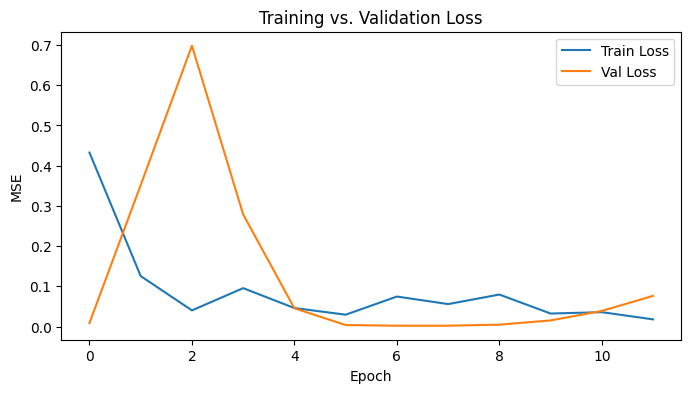

In [15]:
# Plot Training & Validation Loss
plt.figure(figsize=(8,4))
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Val Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend()
plt.show()


# **Use the Best Model for Prediction and Forecasting**

In [16]:
# Iterative 24‐Month Forecast
horizon = 24
last_window = monthly_scaled[-look_back:].reshape(1, look_back, 1)
preds_scaled = []
window = last_window.copy()

for _ in range(horizon):
    p = best_model.predict(window, verbose=0)[0,0]
    preds_scaled.append(p)
    # slide window
    window = np.concatenate([window[:,1:,:], np.array([[[p]]])], axis=1)

pred_scaled = np.array(preds_scaled).reshape(-1,1)
forecast = scaler.inverse_transform(pred_scaled).flatten()


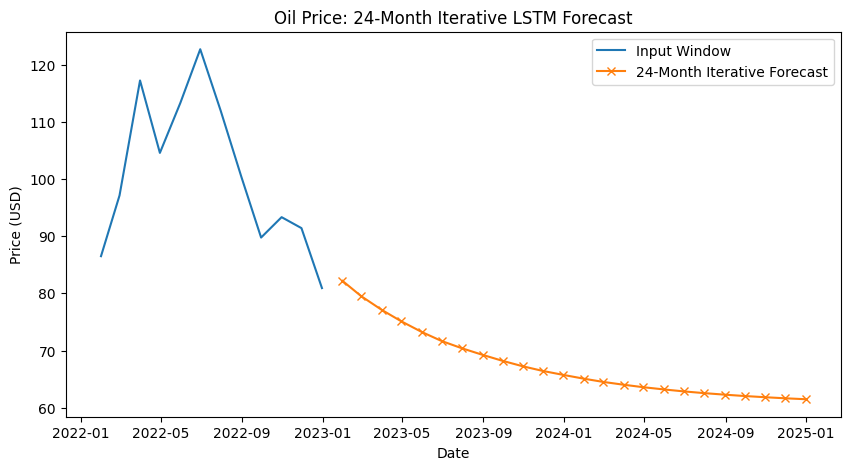

In [17]:
# Plot Forecast
import pandas as pd

last_date = monthly.index[-1]
h_idx     = pd.date_range(last_date + pd.offsets.MonthEnd(1),
                          periods=horizon, freq='M')

plt.figure(figsize=(10,5))
plt.plot(monthly.index[-look_back:], monthly.values[-look_back:], label='Input Window')
plt.plot(h_idx, forecast, marker='x', label='24‐Month Iterative Forecast')
plt.title("Oil Price: 24‐Month Iterative LSTM Forecast")
plt.xlabel("Date"); plt.ylabel("Price (USD)"); plt.legend(); plt.show()


In [18]:
# Compute Validation RMSE in USD (for CI width)
from sklearn.metrics import mean_squared_error
import numpy as np

# 1) Predict on your validation set
val_pred_scaled = best_model.predict(X_val, verbose=0).flatten()
# 2) Invert scaling to USD
val_pred_usd = scaler.inverse_transform(val_pred_scaled.reshape(-1,1)).flatten()
val_true_usd = scaler.inverse_transform(y_val.reshape(-1,1)).flatten()
# 3) Compute RMSE (USD)
val_mse      = mean_squared_error(val_true_usd, val_pred_usd)
val_rmse_usd = np.sqrt(val_mse)
print(f"Validation RMSE (USD): {val_rmse_usd:.2f}")


Validation RMSE (USD): 3.63


In [19]:
# Build 95% CI around your 24-month forecast
ci = 1.96 * val_rmse_usd
lower = forecast - ci
upper = forecast + ci


In [20]:
data_latest = pd.read_csv(
    "/content/drive/MyDrive/Advance Research/Assignment 1/"
    "Oil price data to the current date.csv",
    parse_dates=['Date']
)
data_latest = data_latest.sort_values('Date').set_index('Date')
monthly_latest = data_latest['Price'].resample('M').mean().dropna()


In [21]:
# MC-Dropout Forecast
def mc_dropout_forecast(model, last_window, scaler, horizon=24, n_sims=200):
    """
    Iterative forecasting with dropout active at inference in TF 2.x:
    - model(window, training=True) ensures Dropout layers stay on.
    """
    sims = np.zeros((n_sims, horizon))
    for sim in range(n_sims):
        window = last_window.copy()
        preds = []
        for _ in range(horizon):
            # Forward pass with dropout
            p = model(window, training=True).numpy()[0,0]
            preds.append(p)
            # Slide window forward
            window = np.concatenate([window[:,1:,:], [[[p]]]], axis=1)
        sims[sim] = preds

    # Invert scale: sims shape (n_sims, horizon)
    sims_usd = scaler.inverse_transform(sims.T).T  # now (n_sims, horizon)
    mean_usd   = sims_usd.mean(axis=0)
    lower_usd  = np.percentile(sims_usd, 2.5, axis=0)
    upper_usd  = np.percentile(sims_usd, 97.5, axis=0)
    return mean_usd, lower_usd, upper_usd


last_window = monthly_scaled[-look_back:].reshape(1, look_back, 1)
mc_mean, mc_lower, mc_upper = mc_dropout_forecast(
    best_model, last_window, scaler, horizon=24, n_sims=200
)


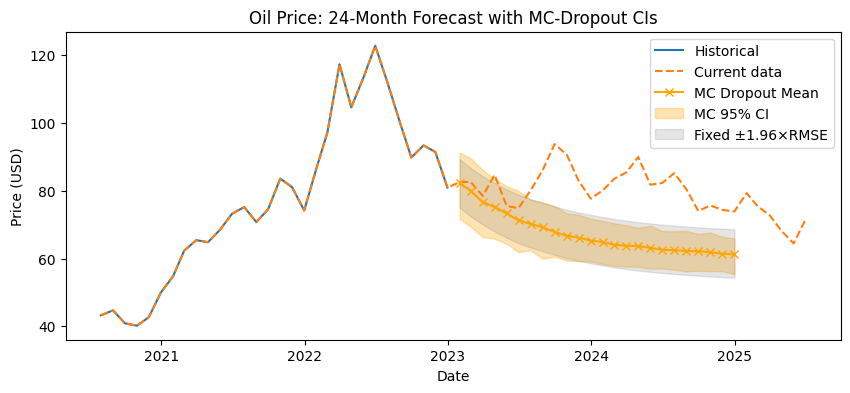

In [26]:
# Plot MC Dropout CIs vs. Fixed RMSE Band
plt.figure(figsize=(10,4))
# historical
plt.plot(monthly.index, monthly.values, label='Historical')
# Current data
plt.plot(monthly_latest.index, monthly_latest.values,
         linestyle='--', label='Current data')
# MC mean forecast
plt.plot(h_idx, mc_mean, marker='x', color='orange', label='MC Dropout Mean')
# MC CI
plt.fill_between(h_idx, mc_lower, mc_upper,
                 color='orange', alpha=0.3, label='MC 95% CI')
# fixed RMSE band for comparison
plt.fill_between(h_idx, lower, upper,
                 color='gray', alpha=0.2, label='Fixed ±1.96×RMSE')

plt.title('Oil Price: 24-Month Forecast with MC-Dropout CIs')
plt.xlabel('Date'); plt.ylabel('Price (USD)'); plt.legend(); plt.show()


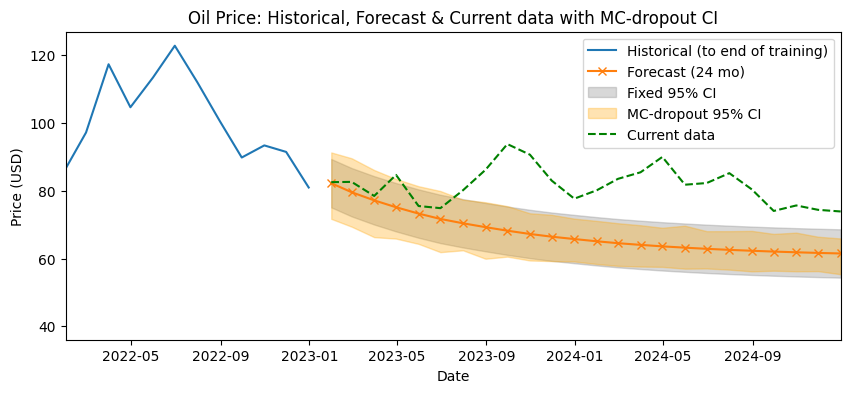

In [28]:
# Merge Historical, Forecast, and Current CSV Data, Then Plot (with MC-dropout CI)
plt.figure(figsize=(10,4))

# 1) Build the forecast index (already defined as h_idx)
last_hist = monthly.index[-1]
h_idx = pd.date_range(last_hist + pd.offsets.MonthEnd(1),
                      periods=horizon, freq='M')

# 2) Align the live data
live_slice = monthly_latest.reindex(h_idx).ffill()

# Plot historical
plt.plot(monthly.index, monthly.values, label='Historical (to end of training)')

# Plot point forecast
plt.plot(h_idx, forecast, marker='x', label='Forecast (24 mo)')

# Fixed ±1.96×RMSE band
plt.fill_between(h_idx, lower, upper,
                 color='gray', alpha=0.3, label='Fixed 95% CI')

# **New**: MC-dropout 95% CI band
plt.fill_between(h_idx, mc_lower, mc_upper,
                 color='orange', alpha=0.3, label='MC-dropout 95% CI')

# Plot actual current data
plt.plot(h_idx, live_slice.values,
         linestyle='--', color='green', label='Current data')

# Zoom x-axis
plt.xlim(monthly.index[-look_back], h_idx[-1])

plt.title('Oil Price: Historical, Forecast & Current data with MC-dropout CI')
plt.xlabel('Date'); plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [24]:
# Compute & Print Final Overlap Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Align forecast and actual CSV data
f = pd.Series(forecast, index=h_idx)
a = monthly_latest.reindex(h_idx).ffill()

common = f.index.intersection(a.index)
f_common = f.loc[common]
a_common = a.loc[common]

rmse_final = np.sqrt(mean_squared_error(a_common, f_common))
mae_final  = mean_absolute_error(a_common, f_common)
mape_final = np.mean(np.abs((a_common - f_common) / a_common)) * 100

start, end = common[0].date(), common[-1].date()
print(f"Overlap period: {start} to {end}")
print(f"  RMSE : ${rmse_final:.2f}")
print(f"  MAE  : ${mae_final:.2f}")
print(f"  MAPE : {mape_final:.1f}%")


Overlap period: 2023-01-31 to 2024-12-31
  RMSE : $15.88
  MAE  : $13.95
  MAPE : 16.8%
